In [1]:
import os
import torch

os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="8"
os.environ["OMP_NUM_THREADS"]="1"

import sys
import json

import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from spatial.merfish_dataset import FilteredMerfishDataset, MerfishDataset, SyntheticDataset0, SyntheticDataset1, SyntheticDataset2, SyntheticDataset3
from spatial.models.monet_ae import MonetAutoencoder2D, TrivialAutoencoder, MonetDense
from spatial.train import train
from spatial.predict import test

from torch.profiler import profile, record_function, ProfilerActivity

# makes the notebook loadable
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import hydra
from hydra.experimental import compose, initialize

with open('../deepST_synthetic_results.json', 'r') as deepST:
    test_loss_rad_dict = json.load(deepST)

for model_architecture in [[512],[128,128,128],[512,512,512]]:
    for rad in range(0, 65, 5):
        for synthetic_exp in [0, 1, 4, 5, 6, 7]:
            if str((rad, synthetic_exp)) not in test_loss_rad_dict:
                test_loss_rad_dict[str((rad, synthetic_exp))] = {}
            with initialize(config_path=f"../../config"):
                cfg_from_terminal = compose(config_name=f"config{synthetic_exp}")
                OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", model_architecture)
                OmegaConf.update(cfg_from_terminal, "training.logger_name", f"synthetic{synthetic_exp}")
                OmegaConf.update(cfg_from_terminal, "radius", rad)
                OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
                OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 0)
                try:
                    output = test(cfg_from_terminal)
                except FileNotFoundError:
                    continue
                trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
                test_loss_rad_dict[str((rad, synthetic_exp))][str(model_architecture)] = test_results[0]['test_loss']

            with open('../deepST_synthetic_results.json', 'w') as deepST:
                json.dump(test_loss_rad_dict, deepST)

In [3]:
with open('../deepST_synthetic_results.json', 'r') as deepST:
    test_loss_rad_dict = json.load(deepST)

In [12]:
test_loss_rad_dict

{'(25, 0)': {'[512]': 0.10236034542322159,
  '[128, 128, 128]': 0.08310852199792862,
  '[512, 512, 512]': 0.08545476943254471},
 '(0, 0)': {'[512]': 0.23553942143917084,
  '[128, 128, 128]': 0.23567447066307068,
  '[512, 512, 512]': 0.23585249483585358},
 '(0, 1)': {'[512]': 0.06582453101873398,
  '[128, 128, 128]': 0.0657385066151619,
  '[512, 512, 512]': 0.06567420810461044},
 '(0, 4)': {'[512]': 0.00047063702368177474,
  '[128, 128, 128]': 0.0007368026999756694,
  '[512, 512, 512]': 0.0005545378662645817},
 '(0, 5)': {'[512]': 0.0009140346082858741,
  '[128, 128, 128]': 0.0011945620644837618,
  '[512, 512, 512]': 0.0009824539301916957},
 '(0, 6)': {'[512]': 0.0028924529906362295,
  '[128, 128, 128]': 0.0031361763831228018,
  '[512, 512, 512]': 0.0029509165324270725},
 '(0, 7)': {'[512]': 0.0032210680656135082,
  '[128, 128, 128]': 0.003469028975814581,
  '[512, 512, 512]': 0.0032999503891915083},
 '(5, 0)': {'[512]': 0.23516085743904114,
  '[128, 128, 128]': 0.23565685749053955,
  '

In [13]:
# update a model in test_loss_rad_dict
import hydra
from hydra.experimental import compose, initialize

for model_architecture in [[128,128,128,128,128,128]]:
    for rad in range(0, 65, 5):
        for synthetic_exp in ["Nonlinear"]:
            if str((rad, synthetic_exp)) not in test_loss_rad_dict:
                test_loss_rad_dict[str((rad, synthetic_exp))] = {}
            with initialize(config_path=f"../../config"):
                cfg_from_terminal = compose(config_name=f"config{synthetic_exp}")
                OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", model_architecture)
                OmegaConf.update(cfg_from_terminal, "training.logger_name", f"synthetic{synthetic_exp}")
                OmegaConf.update(cfg_from_terminal, "radius", rad)
                OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
                OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 0)
                OmegaConf.update(cfg_from_terminal, "training.filepath", f"{cfg_from_terminal.model.name}__{cfg_from_terminal.model.kwargs.hidden_dimensions}__{cfg_from_terminal.model.kwargs.response_genes}__{cfg_from_terminal.radius}__{cfg_from_terminal.training.logger_name}")
#                 OmegaConf.update(cfg_from_terminal, "model.kwargs.aggr", "add")
                if not os.path.exists(f"../../output/lightning_logs/checkpoints/MonetDense/{cfg_from_terminal.training.filepath}.ckpt"):
                    print(f"Could not find file: {cfg_from_terminal.training.filepath}")
                    continue
                output = test(cfg_from_terminal)
                trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
                print(inputs.shape, gene_expressions.shape)
                test_loss_rad_dict[str((rad, synthetic_exp))][str(model_architecture)] = test_results[0]['test_loss']

            with open('../deepST_synthetic_results.json', 'w') as deepST:
                json.dump(test_loss_rad_dict, deepST)

100%|██████████████████████████████████████████████████████████████| 24/24 [00:35<00:00,  1.48s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.005638930946588516
     test_loss: mse        0.005638930946588516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
torch.Size([134392, 155]) torch.Size([134392, 1])


TypeError: 'float' object does not support item assignment

In [18]:
with open('../LightGBM_synthetic_results.json', 'r') as linear:
    linear_models_dict = json.load(linear)

In [68]:
# import json

# with open('../sanity_check.json', 'r') as linear:
#     linear_models_dict = linear_models_dict | json.load(linear)

In [4]:
test_loss_rad_dict, linear_models_dict

({'(25, 0)': {'[512]': 0.10236034542322159,
   '[128, 128, 128]': 0.08310852199792862,
   '[512, 512, 512]': 0.08545476943254471},
  '(0, 0)': {'[512]': 0.23553942143917084,
   '[128, 128, 128]': 0.23567447066307068,
   '[512, 512, 512]': 0.23585249483585358},
  '(0, 1)': {'[512]': 0.06582453101873398,
   '[128, 128, 128]': 0.0657385066151619,
   '[512, 512, 512]': 0.06567420810461044},
  '(0, 4)': {'[512]': 0.00047063702368177474,
   '[128, 128, 128]': 0.0007368026999756694,
   '[512, 512, 512]': 0.0005545378662645817},
  '(0, 5)': {'[512]': 0.0009140346082858741,
   '[128, 128, 128]': 0.0011945620644837618,
   '[512, 512, 512]': 0.0009824539301916957},
  '(0, 6)': {'[512]': 0.0028924529906362295,
   '[128, 128, 128]': 0.0031361763831228018,
   '[512, 512, 512]': 0.0029509165324270725},
  '(0, 7)': {'[512]': 0.0032210680656135082,
   '[128, 128, 128]': 0.003469028975814581,
   '[512, 512, 512]': 0.0032999503891915083},
  '(5, 0)': {'[512]': 0.23516085743904114,
   '[128, 128, 128]': 0

In [19]:
# create dataframe
import pandas as pd

# linear models + XGBoost
data = pd.DataFrame(columns=['Model', 'Radius', 'Experiment #', 'L2 Loss'])
for k,v in linear_models_dict.items():
    k = k.split()
    entry = pd.DataFrame.from_dict({
        'Model': [k[0]],
        'Radius': [int(k[1])],
        'Experiment #': [k[2]],
        'L2 Loss': [v]
    })
    data = pd.concat([data, entry], ignore_index=True)

print(data)


for k,v in test_loss_rad_dict.items():
    try:
        k = eval(k)
        entry = pd.DataFrame.from_dict({
            'Model': 'deepST',
            'Radius': [int(k[0])],
            'Experiment #': [k[1]],
            'L2 Loss': [min(v.values())]
        })
        data = pd.concat([data, entry], ignore_index=True)
    #nonlinear case
    except (AttributeError, ValueError):
        entry = pd.DataFrame.from_dict({
            'Model': 'deepST',
            'Radius': [int(k[0])],
            'Experiment #': [k[1]],
            'L2 Loss': [v]
        })
        data = pd.concat([data, entry], ignore_index=True)
        

data[data["Model"] == "deepST"]

          Model Radius Experiment #   L2 Loss
0      LightGBM      0            0  0.229992
1           OLS      0            0  0.230439
2         Ridge      0            0  0.230426
3         Lasso      0            0  0.231350
4    ElasticNet      0            0  0.230434
..          ...    ...          ...       ...
765    LightGBM     60    Nonlinear  0.004025
766         OLS     60    Nonlinear  0.004079
767       Ridge     60    Nonlinear  0.004079
768       Lasso     60    Nonlinear  0.004424
769  ElasticNet     60    Nonlinear  0.004060

[770 rows x 4 columns]


,Model,Radius,Experiment #,L2 Loss
770,deepST,25,0,0.083109
771,deepST,0,0,0.235539
772,deepST,0,1,0.065674
773,deepST,0,4,0.000471
774,deepST,0,5,0.000914
...,...,...,...,...
869,deepST,40,Nonlinear,0.001109
870,deepST,45,Nonlinear,0.00117
871,deepST,50,Nonlinear,0.001102
872,deepST,55,Nonlinear,0.001078


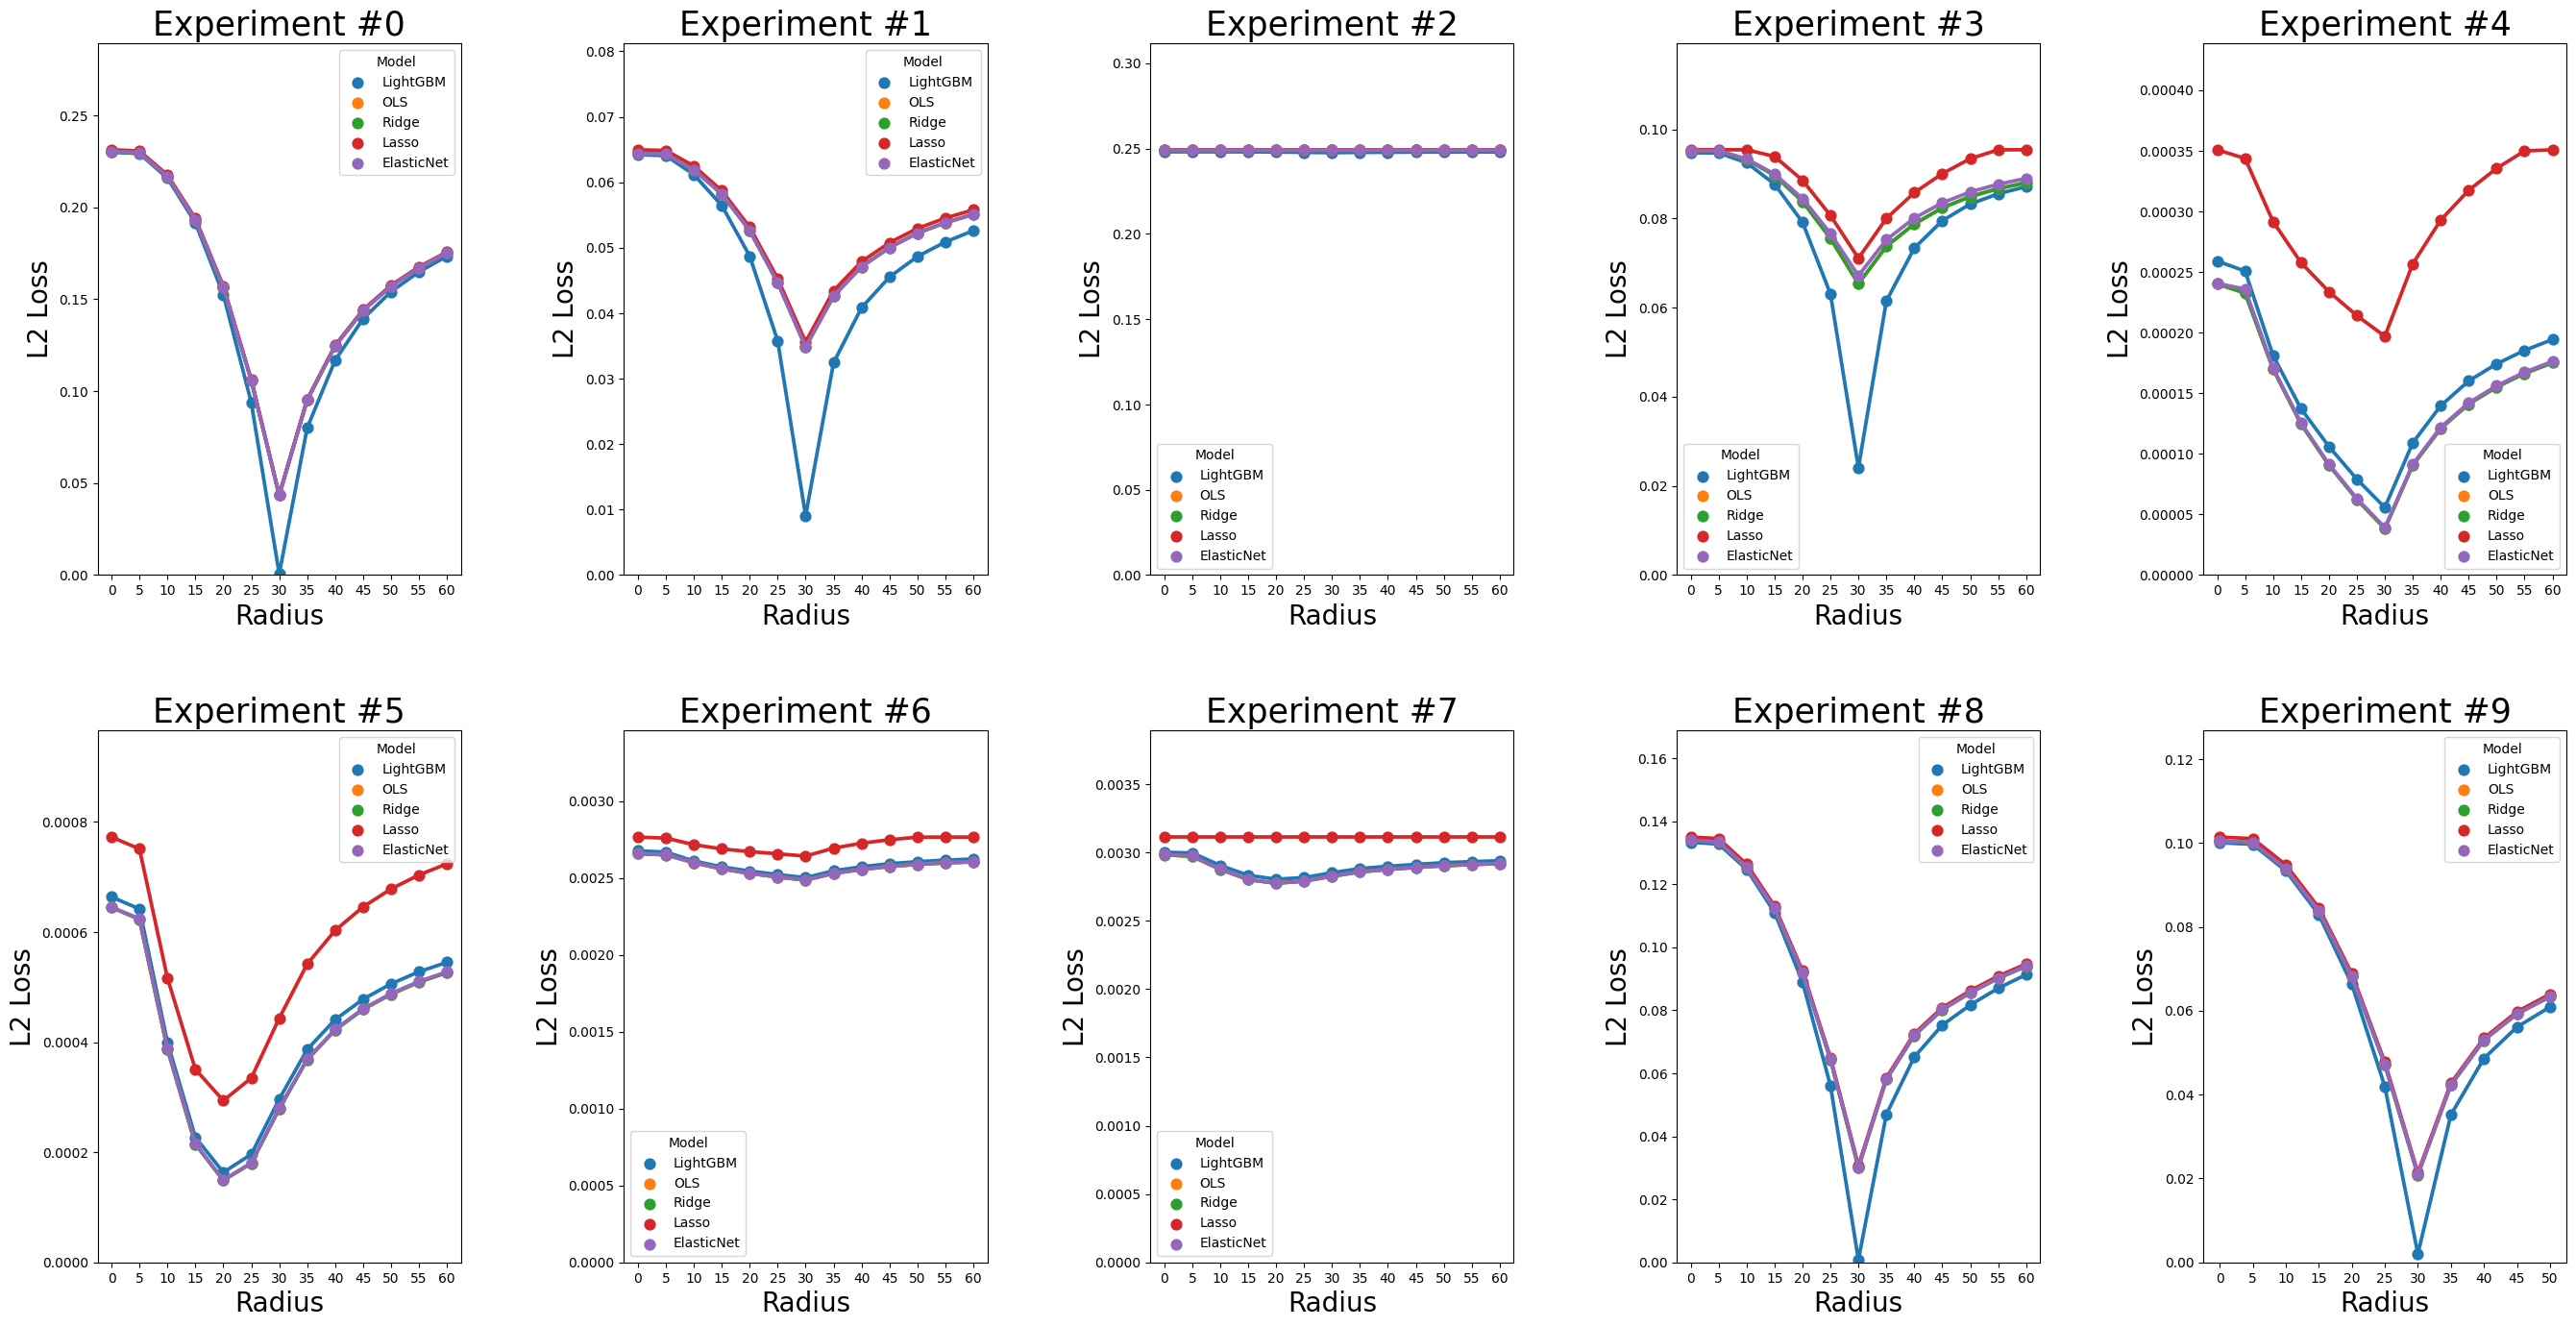

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(28, 15))   

# create pointplot
for exp in list(range(10)):
    new_data = data[data['Experiment #'] == str(exp)]
    synth_results = sns.pointplot(ax=axes[exp // 5, exp % 5], x='Radius', y= 'L2 Loss', hue='Model', data=new_data)
    axes[exp // 5, exp % 5].set_ylim(bottom=0, top=1.25*max(new_data["L2 Loss"]))
    # baseline = new_data[(new_data["Model"] == "deepST") & (new_data["Radius"] == 0)]["L1 Loss"]
    # synth_results.axhline(baseline.item(), linestyle = '-', linewidth=3)
    synth_results.set_title(f"Experiment #{exp}", fontsize=25)
    synth_results.set_xlabel("Radius", fontsize = 20)
    synth_results.set_ylabel("L2 Loss", fontsize = 20)
    fig.tight_layout(pad=5)
plt.savefig(f'synth_experiments.png')

In [17]:
import hydra
from hydra.experimental import compose, initialize

with open('../deepST_synthetic_results.json', 'r') as deepST:
    test_loss_rad_dict = json.load(deepST)

for rad in range(0, 65, 5):
    for synthetic_exp in ["Nonlinear"]:
        if str((rad, synthetic_exp)) not in test_loss_rad_dict:
            test_loss_rad_dict[str((rad, synthetic_exp))] = {}
        with initialize(config_path=f"../../config"):
            cfg_from_terminal = compose(config_name=f"config{synthetic_exp}")
            OmegaConf.update(cfg_from_terminal, "gpus", [1])
            OmegaConf.update(cfg_from_terminal, "model.kwargs.hidden_dimensions", [128,128,128,128,128,128])
            OmegaConf.update(cfg_from_terminal, "training.logger_name", f"synthetic{synthetic_exp}Optim")
            OmegaConf.update(cfg_from_terminal, "radius", rad)
            OmegaConf.update(cfg_from_terminal, "model.kwargs.response_genes", [0])
            OmegaConf.update(cfg_from_terminal, "datasets.dataset.splits", 0)
            OmegaConf.update(cfg_from_terminal, "optimizer.name", "Adam")
            try:
                output = test(cfg_from_terminal)
            except FileNotFoundError:
                print("File not found.")
                continue
            trainer, l1_losses, inputs, gene_expressions, celltypes, test_results = output
            test_loss_rad_dict[str((rad, synthetic_exp))] = test_results[0]['test_loss']

        with open('../deepST_synthetic_results.json', 'w') as deepST:
            json.dump(test_loss_rad_dict, deepST)

100%|██████████████████████████████████████████████████████████████| 24/24 [00:34<00:00,  1.45s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.005246361251920462
     test_loss: mse        0.005246361251920462
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████████████████████████████| 24/24 [00:34<00:00,  1.45s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.005091498140245676
     test_loss: mse        0.005091498140245676
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████████████████████████████| 24/24 [00:35<00:00,  1.46s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0033335310872644186
     test_loss: mse        0.0033335310872644186
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████████████████████████████| 24/24 [00:35<00:00,  1.48s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0020584457088261843
     test_loss: mse        0.0020584457088261843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

100%|██████████████████████████████████████████████████████████████| 24/24 [00:33<00:00,  1.41s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0013515553437173367
     test_loss: mse        0.0013515553437173367
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████████████████████████████| 24/24 [00:36<00:00,  1.52s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0011572297662496567
     test_loss: mse        0.0011572297662496567
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████████████████████████████| 24/24 [00:35<00:00,  1.46s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0010950297582894564
     test_loss: mse        0.0010950297582894564
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

100%|██████████████████████████████████████████████████████████████| 24/24 [00:34<00:00,  1.45s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0011493097990751266
     test_loss: mse        0.0011493097990751266
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

100%|██████████████████████████████████████████████████████████████| 24/24 [00:34<00:00,  1.43s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0011092161294072866
     test_loss: mse        0.0011092161294072866
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

100%|██████████████████████████████████████████████████████████████| 24/24 [00:33<00:00,  1.41s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.001169870258308947
     test_loss: mse        0.001169870258308947
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████████████████████████████| 24/24 [00:33<00:00,  1.41s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.00110160862095654
     test_loss: mse         0.00110160862095654
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████████████████████████████| 24/24 [00:34<00:00,  1.42s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0010782380122691393
     test_loss: mse        0.0010782380122691393
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████████████████████████████████████████████████████████| 24/24 [00:35<00:00,  1.48s/it]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: 0it [00:00, ?it/s]

TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                          	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0011258472222834826
     test_loss: mse        0.0011258472222834826
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


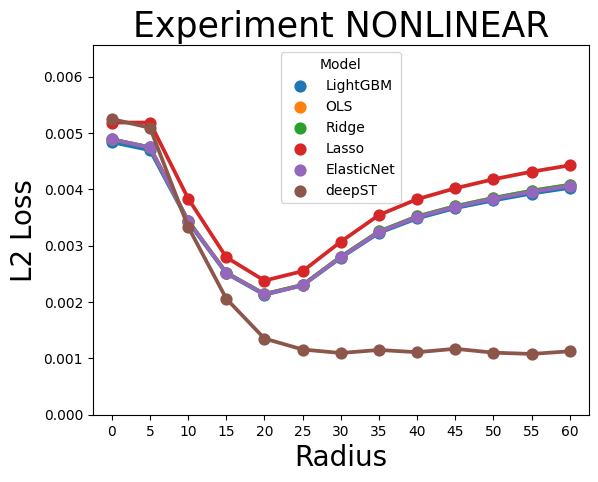

In [22]:
 # create pointplot
new_data = data[data['Experiment #'] == "Nonlinear"]
synth_results = sns.pointplot(x='Radius', y= 'L2 Loss', hue='Model', data=new_data)
synth_results.set_ylim(bottom=0, top=1.25*max(new_data["L2 Loss"]))
# baseline = new_data[(new_data["Model"] == "deepST") & (new_data["Radius"] == 0)]["L1 Loss"]
# synth_results.axhline(baseline.item(), linestyle = '-', linewidth=3)
synth_results.set_title(f"Experiment NONLINEAR", fontsize=25)
synth_results.set_xlabel("Radius", fontsize = 20)
synth_results.set_ylabel("L2 Loss", fontsize = 20)
fig.tight_layout(pad=5)
plt.savefig(f'nonlinear.png')